# DENUE analysis my block -test-

This notebook covers the first steps towards an urban land use classifier. In it:
1. The DENUE database is downloaded for a specific area
2. A classification of the DENUE by activity is assigned to each point
3. Each DENUE point gets assigned to an urban block
4. An iterative process produces a Kernel Density Estimation for each activity classification and each block

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
# import odc
import zipfile

from shapely.geometry import Point, Polygon

import seaborn as sns
import matplotlib.pyplot as plt

# from typing import Optional
from spatial_kde import spatial_kernel_density

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys

from shapely import wkb
import binascii
from sqlalchemy import text

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download and read data

### Area of analysis

In [2]:
aoa_gdf_all = gpd.read_file('all_places_cleaned.geojson')

In [3]:
aoa_gdf_all.head(4)

,gid,id,distrito,shape_leng,shape_area,layer,path,UNuso,geometry
0,119895,95475.0,2.0,54.193112,130.922608,USOS_DE_SUELO_Z2,/Users/eileenyuen/Downloads/OneDrive_1_30-4-20...,Habitacional,"MULTIPOLYGON (((672237.33 2295207.029, 672235...."
1,119896,471562.0,2.0,47.842126,112.073148,USOS_DE_SUELO_Z2,/Users/eileenyuen/Downloads/OneDrive_1_30-4-20...,Habitacional,"MULTIPOLYGON (((669537.234 2295451.983, 669520..."
2,119897,53588.0,2.0,54.517475,144.209492,USOS_DE_SUELO_Z2,/Users/eileenyuen/Downloads/OneDrive_1_30-4-20...,Habitacional,"MULTIPOLYGON (((671188.527 2293497.949, 671187..."
3,119898,70650.0,2.0,52.319930,134.514816,USOS_DE_SUELO_Z2,/Users/eileenyuen/Downloads/OneDrive_1_30-4-20...,Habitacional,"MULTIPOLYGON (((671684.857 2295182.66, 671684...."


In [4]:
aoa_gdf_district_5 = aoa_gdf_all.copy()
aoa_gdf_district_5 = aoa_gdf_district_5[aoa_gdf_district_5["layer"] == "USOS_ZONA_5"]

In [5]:
aoa_gdf_district_5["layer"].unique()

array(['USOS_ZONA_5'], dtype=object)

In [6]:
print(aoa_gdf_district_5.crs)

EPSG:32613


In [7]:
aoa_gdf_district_5["UNuso"] = aoa_gdf_district_5["UNuso"].fillna("Sin_datos")

In [8]:
aoa_gdf_district_5.isna().sum()

gid           0
id            4
distrito      0
shape_leng    4
shape_area    4
layer         0
path          0
UNuso         0
geometry      0
dtype: int64

In [9]:
aoa_gdf_district_5.columns.tolist()

['gid',
 'id',
 'distrito',
 'shape_leng',
 'shape_area',
 'layer',
 'path',
 'UNuso',
 'geometry']

### Calculating centroids and intersecting with "Zona5"

In [11]:
poly_d5 = gpd.read_file("Distrito_Zona5.geojson")

In [13]:
aoa_gdf_d5 = gpd.read_file("aoa_d5_centroids.geojson")

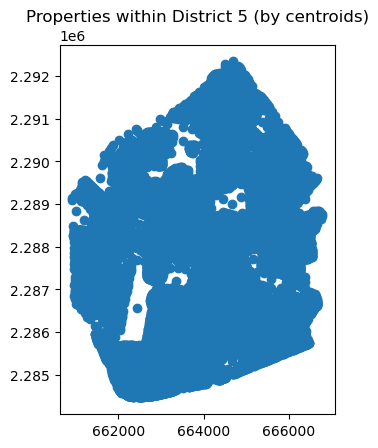

In [26]:
# Ontaining the centroids 
aoa_centroids = aoa_gdf_district_5.copy()
aoa_centroids["geometry"] = aoa_centroids.centroid

# poly_d5 only has one geometry
poly_geom = poly_d5.geometry.iloc[0]

# Filtering the centroids that are only in the polygon
centroids_in_poly = aoa_centroids[aoa_centroids.within(poly_geom)]

# Obtainin unique ids
ids_in_poly = centroids_in_poly["id"].unique()

# Filter the original gdf
aoa_gdf_filtered = aoa_gdf_d5[aoa_gdf_d5["id"].isin(ids_in_poly)]

# Plot thee result
aoa_gdf_filtered.plot()
plt.title("Properties within District 5 (by centroids)")
plt.show()

In [15]:
aoa_gdf_filtered.head()

,gid,id,distrito,shape_leng,shape_area,layer,path,UNuso,geometry
0,383802,225938.0,5.0,87.833373,372.671854,USOS_ZONA_5,/Users/eileenyuen/Downloads/OneDrive_1_30-4-20...,Baldio,POINT (663592.931 2289238.144)
1,383514,465151.0,5.0,156.734778,1505.830715,USOS_ZONA_5,/Users/eileenyuen/Downloads/OneDrive_1_30-4-20...,Sin_datos,POINT (661577.052 2289177.523)
2,383647,465323.0,5.0,102.854373,577.067362,USOS_ZONA_5,/Users/eileenyuen/Downloads/OneDrive_1_30-4-20...,Baldio,POINT (663863.97 2291536.278)
3,383515,465183.0,5.0,389.147415,6545.629993,USOS_ZONA_5,/Users/eileenyuen/Downloads/OneDrive_1_30-4-20...,Comercial,POINT (663128.973 2287036.845)
4,383516,465188.0,5.0,2338.338291,110638.820370,USOS_ZONA_5,/Users/eileenyuen/Downloads/OneDrive_1_30-4-20...,Baldio,POINT (662892.634 2290798.717)


In [16]:
aoa_gdf_filtered["layer"].unique()

array(['USOS_ZONA_5'], dtype=object)

In [17]:
aoa_gdf_filtered.isna().sum()

gid           0
id            4
distrito      0
shape_leng    4
shape_area    4
layer         0
path          0
UNuso         0
geometry      0
dtype: int64

In [18]:
aoa_gdf_filtered.shape

(44927, 9)

In [19]:
aoa_gdf_filtered.crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°W and 102°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### DENUE

In [21]:
aoa_gdf = aoa_gdf_filtered.copy()

In [22]:
aoa_gdf = aoa_gdf.to_crs("EPSG:32613")

print(aoa_gdf.crs)  

if aoa_gdf.crs.to_epsg() != 32613:
    aoa_gdf = aoa_gdf.to_crs("EPSG:32613")

# Converting to WKT
poly_wkt = aoa_gdf.geometry.iloc[0].wkt

EPSG:32613


In [23]:
print(type(poly_wkt))  # Debe ser <class 'str'>

<class 'str'>


In [24]:
print(aoa_gdf.is_empty.sum())  # Empty geometries
print(aoa_gdf.geometry.is_valid.sum())  # Valid geometries

0
44927


In [27]:
print(poly_wkt)

POINT (663592.9313066297 2289238.144367153)


In [30]:
schema = "denue"
table = "denue_2022"

query_censo = f"""
SELECT
    id,
    cve_ent AS entidad,
    cve_loc AS localidad,
    manzana,
    cve_mun AS municipio,
    latitud,
    longitud,
    codigo_act,
    ageb,
    per_ocu,
    ST_AsText(geometry) AS geometry
FROM {schema}.{table}
WHERE ST_Intersects(
    geometry,
    ST_Buffer(ST_GeomFromText('{poly_wkt}', 32613), 100)
)
"""
 
denue_gdf = aup.gdf_from_query(query_censo, geometry_col='geometry')
denue_gdf['geometry'] = denue_gdf['geometry'].apply(wkt.loads)
denue_gdf = gpd.GeoDataFrame(denue_gdf, geometry='geometry', crs='EPSG:32613')

print(denue_gdf.shape)
print(denue_gdf.head())

(0, 11)
Empty GeoDataFrame
Columns: [id, entidad, localidad, manzana, municipio, latitud, longitud, codigo_act, ageb, per_ocu, geometry]
Index: []


### Census blocks

In [39]:
schema = "sociodemografico"
table = "censo_inegi_20_mza"

# Consulta SQL
query_censo = f"""
SELECT 
  cvegeo_mza,
  pobtot,
  ST_AsText(geometry) AS geometry
FROM {schema}.{table}
WHERE ST_Intersects(
  geometry,
  ST_SetSRID(ST_MakeValid(ST_GeomFromText('{poly_wkt}')), 32613)
)
"""

censo_gdf = aup.gdf_from_query(query_censo, geometry_col="geometry")

# Result
print(censo_gdf.shape)
print(censo_gdf.head())

(0, 3)
Empty GeoDataFrame
Columns: [cvegeo_mza, pobtot, geometry]
Index: []


## Data treatment and preprocessing

### DENUE classification by activity

Clasificar las distintas actividades económicas con base en su terminación en "codigo_act" basándonos en el Directorio Estadístico Nacional de Unidades Económicas

In [14]:
# Función para clasificar según la terminación de codigo_act
def asignar_tipo(codigo):
    if pd.isna(codigo):  # Si está vacío
        return 'Sin código'
    
    # Asegurar que sea string para evaluar el código
    codigo_str = str(codigo).strip()

    if not codigo_str.isdigit():
        return 'Código inválido'
    
    # Define tus conjuntos de códigos
    industria = {'11', '21', '23', '31', '32', '33', '55'}
    
    servicios = {'22', '48', '49', '52', '53', '54', '56', '72',
                 '81'}
    
    comercio = {'43', '46'}
    
    cultural_recreativo = {'51','71'}
    
    educacion = {'61'}
    
    salud = {'62'}

    gobierno = {'93'}
    
    # Verificar si el código está en alguno de los conjuntos
    if codigo_str[:2] in industria:
        return 'Industria'
    elif codigo_str[:2] in servicios:
        return 'Servicios'
    elif codigo_str[:2] in comercio:
        return 'Comercio'
    elif codigo_str[:2] in cultural_recreativo:
        return 'Cultural_Recreativo'
    elif codigo_str[:2] in educacion:
        return 'Educación'
    elif codigo_str[:2] in salud:
        return 'Salud'
    elif codigo_str[:2] in gobierno:
        return 'Gobierno'
    else:
        return 'Desconocido'

# Aplica la función al DataFrame
denue_gdf['tipo_act'] = denue_gdf['codigo_act'].apply(asignar_tipo)

In [15]:
denue_gdf.head(3)

,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act
0,1829669,14,0001,040,120,20.777288,-103.445935,312112,6635,0 a 5 personas,POINT (-103.44593 20.77729),Industria
1,1829668,14,0001,038,120,20.779729,-103.446429,312112,6635,0 a 5 personas,POINT (-103.44643 20.77973),Industria
2,1704486,14,0001,005,120,20.773346,-103.446032,311830,6705,0 a 5 personas,POINT (-103.44603 20.77335),Industria


In [16]:
denue_gdf["tipo_act"].unique()

array(['Industria', 'Comercio', 'Servicios', 'Educación', 'Salud',
       'Cultural_Recreativo', 'Gobierno'], dtype=object)

In [17]:
len(denue_gdf[denue_gdf['tipo_act'] == 'Desconocido'])

0

### DENUE occupied personel

Contabilizar cuántas personas hay ejerciendo cada actividad económica

In [18]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [19]:
denue_gdf['per_ocu_num'] = denue_gdf.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))
denue_gdf.head(2)

,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num
0,1829669,14,0001,040,120,20.777288,-103.445935,312112,6635,0 a 5 personas,POINT (-103.44593 20.77729),Industria,3
1,1829668,14,0001,038,120,20.779729,-103.446429,312112,6635,0 a 5 personas,POINT (-103.44643 20.77973),Industria,3


### DENUE to blocks

Create CVEGEO code for each DENUE

In [20]:
denue_gdf['cvegeo_mza'] = (
    denue_gdf['entidad'].astype(str).str[:2] +
    denue_gdf['municipio'].astype(str).str[:3] +
    denue_gdf['localidad'].astype(str).str[:4] +
    denue_gdf['ageb'].astype(str).str[:4] +
    denue_gdf['manzana'].astype(str).str[:3]
)
print(denue_gdf.shape)
denue_gdf.head(2)

(52127, 14)


,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza
0,1829669,14,0001,040,120,20.777288,-103.445935,312112,6635,0 a 5 personas,POINT (-103.44593 20.77729),Industria,3,1412000016635040
1,1829668,14,0001,038,120,20.779729,-103.446429,312112,6635,0 a 5 personas,POINT (-103.44643 20.77973),Industria,3,1412000016635038


In [21]:
denue_gdf.cvegeo_mza.apply(len).min() # checks if every element has a 16 character length

16

Test if every DENUE is assigned to a block

In [22]:
denue_gdf.merge(block_gdf[['cvegeo_mza','pobtot']], on='cvegeo_mza', how='inner').pobtot.isna().sum()

0

### Distance from DENUE to block centroids

In [23]:
# 1. Crear GeoDataFrame de manzanas con centroides únicos
block_cnt = block_gdf.copy()
block_cnt['cnt_geometry'] = block_cnt['geometry'].centroid

/tmp/ipykernel_70229/3273052898.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  block_cnt['cnt_geometry'] = block_cnt['geometry'].centroid


In [24]:
# 2. Merge block centroid geometry to DENUE gdf
denue_gdf = pd.merge(
    denue_gdf,
    block_cnt[['cvegeo_mza', 'cnt_geometry']],
    on=['cvegeo_mza'],
    how='inner'
)
print(denue_gdf.shape)
denue_gdf.head(2)

(51885, 15)


,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry
0,1829669,14,0001,040,120,20.777288,-103.445935,312112,6635,0 a 5 personas,POINT (-103.44593 20.77729),Industria,3,1412000016635040,POINT (-103.44613 20.77705)
1,9013984,14,0001,040,120,20.776958,-103.445862,465111,6635,0 a 5 personas,POINT (-103.44586 20.77696),Comercio,3,1412000016635040,POINT (-103.44613 20.77705)


In [25]:
# 3. Calcular la distancia de cada punto al centroide de su manzana
denue_gdf['distancia'] = denue_gdf['geometry'].distance(denue_gdf['cnt_geometry'])

/tmp/ipykernel_70229/4255178002.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  denue_gdf['distancia'] = denue_gdf['geometry'].distance(denue_gdf['cnt_geometry'])


In [26]:
# 4. Calcular d_mean por manzana
denue_to_cnt = denue_gdf.groupby(
    ['cvegeo_mza']
)['distancia'].mean().reset_index(name='d_mean')
print(denue_to_cnt.shape)
denue_to_cnt.head(2)

(8061, 2)


,cvegeo_mza,d_mean
0,1409704240975002,0.000824
1,1409704240975028,0.000608


In [27]:
# Add average distance to each block centroid
denue_gdf = denue_gdf.merge(denue_to_cnt, on='cvegeo_mza')
print(denue_gdf.shape)
denue_gdf.head(2)

(51885, 17)


,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry,distancia,d_mean
0,1829669,14,0001,040,120,20.777288,-103.445935,312112,6635,0 a 5 personas,POINT (-103.44593 20.77729),Industria,3,1412000016635040,POINT (-103.44613 20.77705),0.000307,0.000278
1,9013984,14,0001,040,120,20.776958,-103.445862,465111,6635,0 a 5 personas,POINT (-103.44586 20.77696),Comercio,3,1412000016635040,POINT (-103.44613 20.77705),0.000286,0.000278


<Axes: >

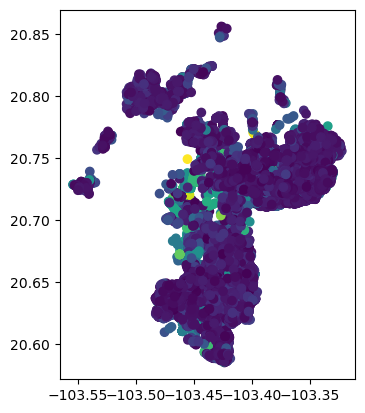

In [28]:
denue_gdf.plot('d_mean')

## Kernel density analysis

#### Single block test

In [29]:
# Obtener el conteo por manzana
conteo_por_manzana = denue_gdf.groupby('cvegeo_mza').size().reset_index(name='conteo')

# Encontrar la manzana con máximo conteo
max_row = conteo_por_manzana.loc[conteo_por_manzana['conteo'].idxmax()]
cvegeo_max = max_row['cvegeo_mza']

In [30]:
block_test = block_gdf.loc[block_gdf.cvegeo_mza==cvegeo_max].copy()

denue_test = denue_gdf.loc[denue_gdf.cvegeo_mza==cvegeo_max].copy()
denue_test = denue_test.reset_index(drop=True)

print(denue_test.shape)
denue_test.head(2)

(298, 17)


,id,entidad,localidad,manzana,municipio,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry,distancia,d_mean
0,6873851,14,0001,015,120,20.651590,-103.402214,713299,066A,51 a 100 personas,POINT (-103.40221 20.65159),Cultural_Recreativo,75,141200001066A015,POINT (-103.40176 20.65035),0.001320,0.001378
1,1811329,14,0001,015,120,20.651738,-103.402117,722511,066A,6 a 10 personas,POINT (-103.40212 20.65174),Servicios,8,141200001066A015,POINT (-103.40176 20.65035),0.001432,0.001378


In [32]:
denue_test.per_ocu_num.unique()

array([ 75,   8,   3,  20,  40, 175])

In [31]:
# Ejecutar el KDE solo sobre esos puntos
spatial_kernel_density(
    points=denue_test,
    radius = denue_test['d_mean'].mean()/2,
    output_path="figureskde_manzana_prueba_todos_los_predios.tif",
    output_pixel_size=5,
    output_driver="GTiff",
    weight_col="per_ocu_num", # Número de personas por ocupación
)

### Iterative analysis

Analysis for every block and economic activity classification

In [ ]:
output_dir = 'figureskde_manzana_prueba_todos_los_predios.tif'
for idx, manzana in block_gdf.iterrows():
    # Filtrar puntos DENUE dentro de la manzana y con la actividad deseada
    cvegeo_mza = block_gdf.loc[idx].cvegeo_mza
    denue_block = denue_gdf.loc[denue_gdf.cvegeo_mza == cvegeo_mza].copy()

    # Saltar si no hay puntos que cumplan ambos criterios
    if denue_block.empty:
        continue

    # Nombre de salida con ID y nombre de actividad
    for act in denue_block.tipo_act.unique():
        output_file = f"{output_dir}kde_mnz_{cvegeo_mza}_{act}.tif"
        denue_act = denue_block.loc[denue_block.tipo_act==act].copy()
        denue_act = denue_act.reset_index(drop=True)

    
        # Ejecutar el KDE
        spatial_kernel_density(
            points=denue_act,
            radius = (denue_block['d_mean'].mean() / 2),
            output_path=output_file,
            output_pixel_size=1.0,
            output_driver="GTiff",
            weight_col="per_ocu_num",
        )
